# C 컴파일 모델 로드 테스트

In [9]:
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 파이썬 Local O3 학습 모델 로드
model_tf = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/PM25_MODEL_v1')

# C 컴파일링(공유 라이브러리) Local O3 모델 로드
model_c = ctypes.CDLL("/home/user/workdir/CMAQ_Emulator/pm25_model_compile/build/libpm25_model.so")
model_c.call.argtypes = [
    ctypes.POINTER(ctypes.c_float),  # c_inputs
    ctypes.POINTER(ctypes.c_float),  # c_bc_inputs
    ctypes.POINTER(ctypes.c_float),  # c_outputs
    ctypes.c_int                     # batch_size
]
model_c.call.restype = None

# 터이터셋 로드
batch_size = 3

ctrl_mat = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019.csv', index_col=0).astype(np.float32)
bc = np.random.uniform(0.5, 1.0, (batch_size, 1)).astype(np.float32) # boundary condition

In [10]:
inputs = ctrl_mat.sample(n=batch_size).values.astype(np.float32)
pred_1 = np.zeros((batch_size, 82, 67, 1)).astype(np.float32)

In [11]:
model_c.call(
    inputs.reshape(-1).ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    bc.reshape(-1).ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    pred_1.reshape(-1).ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    ctypes.c_int(batch_size)
)
print("C 모델 결과 일부:", pred_1[0,0,0,0], pred_1[0,10,10,0])

C 모델 결과 일부: 4.3893805 4.8989177


In [12]:
pred_0 = model_tf.predict([inputs.reshape(batch_size, 17*5), bc], verbose=0)

In [13]:
print(pred_0.shape)
print(pred_1.shape)

(3, 82, 67, 1)
(3, 82, 67, 1)


In [14]:
n_samples = pred_0.shape[0]  # 테스트 샘플 수
pred_0 = pred_0.reshape(n_samples, 82, 67, 1)
pred_1 = pred_1.reshape(n_samples, 82, 67, 1)

In [15]:
print(pred_0.shape)
print(pred_1.shape)

(3, 82, 67, 1)
(3, 82, 67, 1)


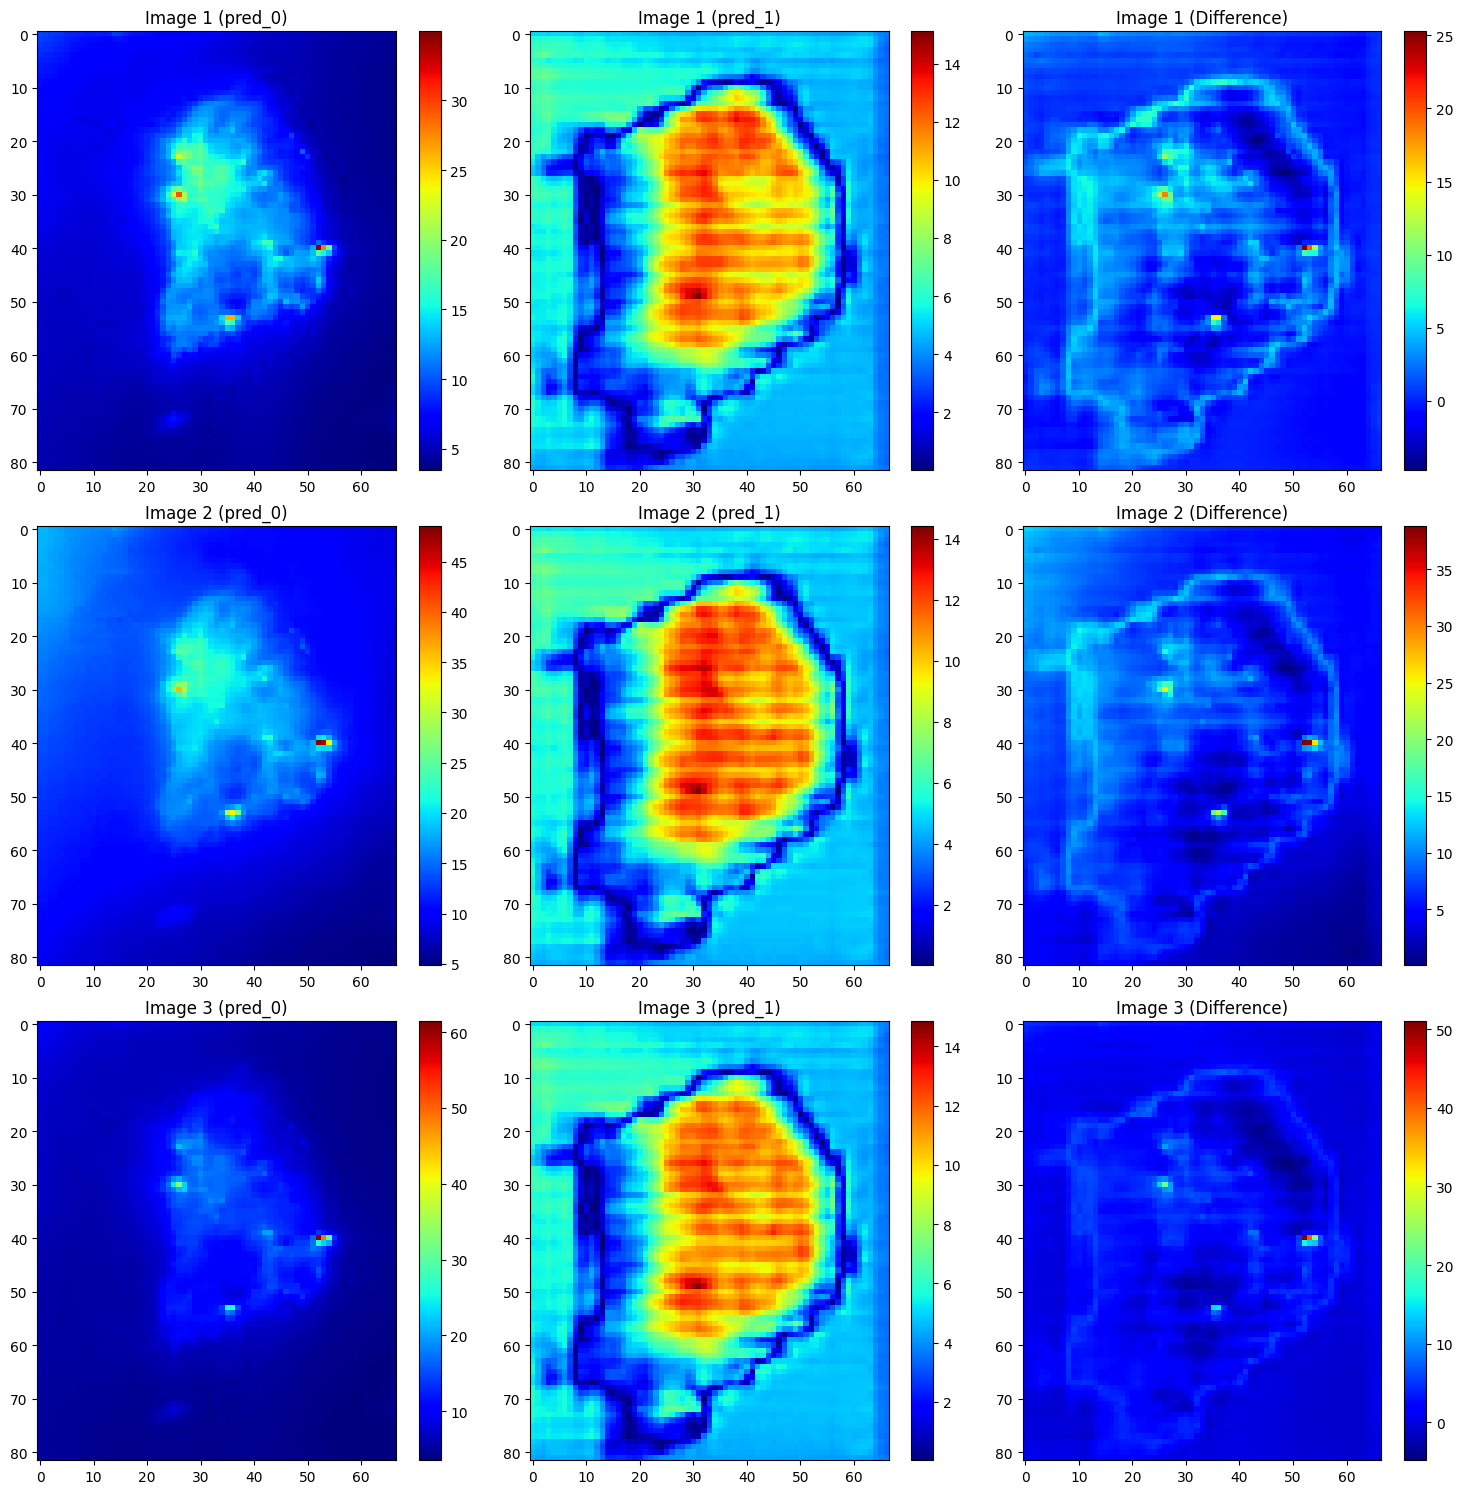

In [16]:
num_images = batch_size  # pred_0과 pred_1에 저장된 이미지 개수
fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(15, 5 * num_images))

for i in range(num_images):
    # 파이썬 모델의 이미지 시각화
    ax = axes[i, 0]
    im0 = ax.imshow(pred_0[i][::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (pred_0)')
    plt.colorbar(im0, ax=ax)

    # 공유 라이브러리 모델의 이미지 시각화
    ax = axes[i, 1]
    im1 = ax.imshow(pred_1[i][::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (pred_1)')
    plt.colorbar(im1, ax=ax)

    # 두 모델 간 차이 이미지 시각화
    ax = axes[i, 2]
    diff = pred_0[i] - pred_1[i]
    im_diff = ax.imshow(diff[::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (Difference)')
    plt.colorbar(im_diff, ax=ax)

plt.tight_layout()
plt.show()